In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
import warnings
import itertools
import seaborn
import matplotlib.dates as md 
import matplotlib
import matplotlib.pyplot as plt

warningsfilterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('DATOS_COMPLETOS.csv', delimiter=';', parse_dates=['DateObserved'])
df.head(10)

Id   Machine              DateStr        DateObserved     H     V    C
0  921880  Batidora  01/09/2018 13:39:16 2018-09-01 13:39:16  0.18  0.14  0.1
1  921881  Batidora  01/09/2018 13:39:46 2018-09-01 13:39:46  0.17  0.15  0.1
2  921882  Batidora  01/09/2018 13:40:15 2018-09-01 13:40:15  0.17  0.17  0.1
3  921883  Batidora  01/09/2018 13:42:56 2018-09-01 13:42:56  0.17  0.16  0.1
4  921884  Batidora  01/09/2018 13:43:26 2018-09-01 13:43:26  0.17  0.19  0.1
5  921885  Batidora  01/09/2018 13:43:56 2018-09-01 13:43:56  0.20  0.18  0.1
6  921886  Batidora  01/09/2018 13:44:26 2018-09-01 13:44:26  0.18  0.17  0.1
7  921887  Batidora  01/09/2018 13:44:55 2018-09-01 13:44:55  0.18  0.17  0.1
8  921888  Batidora  01/09/2018 13:45:25 2018-09-01 13:45:25  0.22  0.16  0.1
9  921889  Batidora  01/09/2018 13:45:55 2018-09-01 13:45:55  0.18  0.16  0.1

In [ ]:
batidora = df.loc[df['Machine'] == 'Batidora']
cols = ['Id', 'DateStr', 'Machine']
batidora.drop(cols, axis=1, inplace=True)
batidora = batidora.set_index('DateObserved')

In [ ]:
batidora.isnull().sum()

H    28
V     0
C     7
dtype: int64

In [ ]:
batidora_resample15m = batidora.resample("15min").mean()
batidora_resample15m['H'].fillna(batidora_resample15m["H"].min(),inplace=True)
batidora_resample15m['C'].fillna(batidora_resample15m["C"].min(),inplace=True)
batidora_resample15m['V'].fillna(batidora_resample15m["V"].min(),inplace=True)
batidora_resample15m.head()

H         V         C
DateObserved                                     
2018-09-01 13:30:00  0.177500  0.166250  0.100000
2018-09-01 13:45:00  0.181667  0.169000  0.100000
2018-09-01 14:00:00  0.183871  0.166452  0.100323
2018-09-01 14:15:00  0.190323  0.170968  0.102581
2018-09-01 14:30:00  0.195806  0.183871  0.100000

In [ ]:
import plotly.express as px
fig = px.line(batidora_resample15m, y=['H','V','C'])
fig.show()

ISOLATION FOREST

In [ ]:
#Take useful feature and standardize them
outliers_fraction=0.01
data = batidora_resample15m[['H', 'V', 'C']]

#train isolation forest
model = IsolationForest(contamination=outliers_fraction, n_estimators=1000, max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=1)
model.fit(data)
iso_predictions = model.predict(data)
iso_score = model.score_samples(data)

batidora_resample15m['anomaly2'] = iso_predictions.tolist()
batidora_resample15m['distance2'] = iso_score.tolist()
batidora_resample15m['anomaly2'] = batidora_resample15m['anomaly2'].map({1: 0, -1:1})



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



In [ ]:
batidora_resample15m['anomaly2'].value_counts()

0    22901
1      232
Name: anomaly2, dtype: int64

In [ ]:
batidora_resample15m.head()

H         V         C  anomaly2  distance2
DateObserved                                                          
2018-09-01 13:30:00  0.177500  0.166250  0.100000         0  -0.375132
2018-09-01 13:45:00  0.181667  0.169000  0.100000         0  -0.373387
2018-09-01 14:00:00  0.183871  0.166452  0.100323         0  -0.378695
2018-09-01 14:15:00  0.190323  0.170968  0.102581         0  -0.393741
2018-09-01 14:30:00  0.195806  0.183871  0.100000         0  -0.365489

In [ ]:
batidora_resample15m['probabilty2'] = batidora_resample15m['distance2'].abs()*100
batidora_resample15m['level2'] = 'low'
batidora_resample15m['level2'] = np.where((batidora_resample15m['probabilty2']>=50) & (batidora_resample15m['anomaly2']==1), 'medium', 'low')
batidora_resample15m['level2'] = np.where((batidora_resample15m['probabilty2']>=60) & (batidora_resample15m['anomaly2']==1), 'high', batidora_resample15m['level2'])
batidora_resample15m['level2'] = np.where((batidora_resample15m['probabilty2']>=75) & (batidora_resample15m['anomaly2']==1), 'critical', batidora_resample15m['level2'])
batidora_resample15m['level2'].value_counts()

low         22901
high          185
critical       47
Name: level2, dtype: int64

In [ ]:
batidora_resample15m.head()

H         V         C  anomaly2  distance2  \
DateObserved                                                             
2018-09-01 13:30:00  0.177500  0.166250  0.100000         0  -0.375132   
2018-09-01 13:45:00  0.181667  0.169000  0.100000         0  -0.373387   
2018-09-01 14:00:00  0.183871  0.166452  0.100323         0  -0.378695   
2018-09-01 14:15:00  0.190323  0.170968  0.102581         0  -0.393741   
2018-09-01 14:30:00  0.195806  0.183871  0.100000         0  -0.365489   

                     probabilty2 level2  
DateObserved                             
2018-09-01 13:30:00    37.513236    low  
2018-09-01 13:45:00    37.338710    low  
2018-09-01 14:00:00    37.869479    low  
2018-09-01 14:15:00    39.374150    low  
2018-09-01 14:30:00    36.548875    low

PINTAR ANOMALIAS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



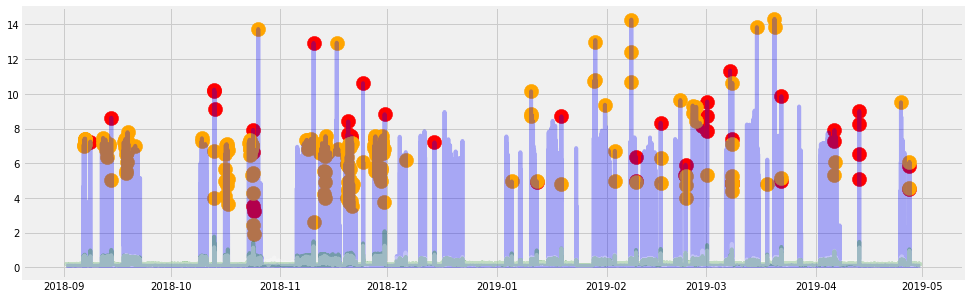

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
resultado = batidora_resample15m[['H', 'V', 'C', 'anomaly2', 'level2']]
resultado['DateObserved'] = batidora_resample15m.index
criticas = resultado.loc[(resultado['anomaly2']==1)&(resultado['level2']=='critical')]
altas = resultado.loc[(resultado['anomaly2']==1) & (resultado['level2']=='high')]
ax.scatter(criticas['DateObserved'], criticas['C'], color='red', s=200)
ax.scatter(altas['DateObserved'], altas['C'], color='orange', s=200)
ax.plot(resultado['DateObserved'], resultado['C'], color='blue', alpha=0.3)
ax.plot(resultado['DateObserved'], resultado['H'], color='green', alpha=0.3)
ax.plot(resultado['DateObserved'], resultado['V'], color='white', alpha=0.3)
plt.show()

In [ ]:
import plotly.graph_objects as go 
fig = go.Figure()
fig.add_trace(go.Scatter(x=batidora_resample15m.index, y=batidora_resample15m['H'],
                         mode='lines',
                         name='lines'))
fig.add_trace(go.Scatter(x=batidora_resample15m.index, y=batidora_resample15m['V'],
                         mode='lines',
                         name='lines'))
fig.add_trace(go.Scatter(x=criticas.index, y=criticas['H'],
                         mode='markers',
                         name='markers'))
fig.show()